In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow.keras as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
model = tf.models.load_model("drive/My Drive/saved_models/chest_xray_model.h5")

In [0]:
data_gen = ImageDataGenerator()

In [0]:
#preprocessing data (data augmentation)

train_data = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [0]:
train_data = data_gen.flow_from_directory('drive/My Drive/Data/chest x-ray dataset/chest_xray/train/', target_size=(224, 224), class_mode='binary', batch_size=32)
X, y = train_data.next()

Found 5056 images belonging to 2 classes.


In [0]:
print(train_data.class_indices)

{'NORMAL': 0, 'PNEUMONIA': 1}


In [0]:
predictions = model.predict(X)

In [0]:
for _y, y_hat in zip(y, predictions):
  print(_y, "-", y_hat)

1.0 - [0.98258483]
1.0 - [0.9972493]
1.0 - [0.93401664]
1.0 - [0.97087353]
1.0 - [0.9601258]
1.0 - [0.9923495]
1.0 - [0.9976679]
1.0 - [0.7989512]
1.0 - [0.9803552]
1.0 - [0.99780715]
1.0 - [0.78362316]
1.0 - [0.99952745]
1.0 - [0.99828386]
1.0 - [0.6137435]
1.0 - [0.9995514]
1.0 - [0.9574026]
1.0 - [0.974424]
0.0 - [0.07204127]
1.0 - [0.94708425]
1.0 - [0.99997723]
1.0 - [0.99999917]
1.0 - [0.9978699]
1.0 - [0.9916079]
1.0 - [0.99997616]
1.0 - [0.9974754]
1.0 - [0.9953817]
1.0 - [0.9974108]
1.0 - [0.9818667]
1.0 - [0.99083734]
1.0 - [0.92592484]
1.0 - [0.9800676]
1.0 - [0.98584056]


In [0]:
# This is the "african elephant" entry in the prediction vector
pred = model.output[:, 0]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model.get_layer('conv2d_23')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `conv2d_23`
grads = K.gradients(pred, last_conv_layer.output)[0]

# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `conv2d_23`,
# given a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image
pooled_grads_value, conv_layer_output_value = iterate([X])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

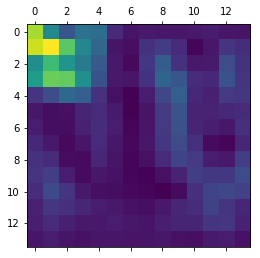

In [0]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

W0722 22:48:10.568241 140544042235776 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

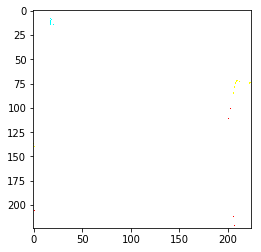

In [0]:
img = "sample_image.png"
cv2.imwrite(img, X[0])

# We use cv2 to load the original image
img = cv2.imread(img)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

plt.imshow(superimposed_img)
cv2.imwrite("heat_map.png", superimposed_img)

In [0]:
# getting all layer names
for layer in model.layers:
    print(layer.name)

Conv_Layer_1
conv2d_12
max_pooling2d_5
dropout_8
conv2d_13
conv2d_14
max_pooling2d_6
dropout_9
conv2d_15
conv2d_16
conv2d_17
max_pooling2d_7
dropout_10
conv2d_18
conv2d_19
conv2d_20
max_pooling2d_8
dropout_11
conv2d_21
conv2d_22
conv2d_23
max_pooling2d_9
dropout_12
flatten_1
dense_4
dropout_13
dense_5
dropout_14
dense_6
dropout_15
dense_7


In [0]:
# from tensorflow import lite
# converter = lite.TFLiteConverter.from_keras_model_file("drive/My Drive/saved_models/chest_xray_model.h5")
# tfmodel = converter.convert()
# open ("model.tflite" , "wb") .write(tfmodel)

W0722 23:56:59.488793 140544042235776 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/lite/python/util.py:238: convert_variables_to_constants (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
W0722 23:56:59.490248 140544042235776 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/graph_util_impl.py:270: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


164255648

In [0]:
import tensorflow as tf
import numpy as np

interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

print(interpreter.get_input_details()[0]['shape'])  
print(interpreter.get_input_details()[0]['dtype']) 

print(interpreter.get_output_details()[0]['shape'])  
print(interpreter.get_output_details()[0]['dtype']) 

[  1 224 224   3]
<class 'numpy.float32'>
[1 1]
<class 'numpy.float32'>
